# Install Dependencies

In [1]:
%pip install langchain_openai==0.3.2 langgraph==0.2.68 langchain-community==0.3.16 langchain-experimental==0.3.4 langchain-core==0.3.32 ipython==8.31.0 pydantic-settings==2.7.1 httpx==0.28.1

Note: you may need to restart the kernel to use updated packages.


# Setup Environment

In [2]:
import os
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_postgres import PGVector

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

CONNECTION = os.getenv('CONNECTION')
COLLECTION_NAME = os.getenv('COLLECTION_NAME')

llm = ChatOpenAI(model='gpt-4o-mini')
embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

vector_store = PGVector(
    embeddings=embeddings,
    collection_name=COLLECTION_NAME,
    connection=CONNECTION,
    use_jsonb=True,
)

# Setup Schemas

In [102]:
import httpx
from typing import Optional

from pydantic import BaseModel, Field


class APIToolSchema(BaseModel):
    pass


class RAGToolSchema(BaseModel):
    question: str = Field(default='', description='question to perform similarity search in vector store')

# Setup Tools

In [103]:
from typing import Type
from langchain_core.prompts import ChatPromptTemplate
from langchain.tools import BaseTool
from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from pydantic_settings import BaseSettings
from langchain_postgres import PGVector
from langchain import hub


class APITool(BaseTool, BaseSettings):
    name: str = 'api_tool'
    description: str = """Tool that calls GET on <http://localhost:8081/players> apis and get uptodate information about players."""
    args_schema: Type[APIToolSchema] = APIToolSchema
    base_url: str = 'http://localhost:8081/players'

    def _run(
            self,
            run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool"""
        result = httpx.Client().get(self.base_url)

        return result.json()

    async def _arun(
            self,
            run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool asynchronously."""

        async with httpx.AsyncClient() as client:
            result = await client.get(self.base_url)
            return result.json()


class RAGTool(BaseTool, BaseSettings):
    name: str = 'rag_tool'
    description: str = """Tool that gets the most similar documents from the vector database."""
    args_schema: Type[RAGToolSchema] = RAGToolSchema
    prompt: ChatPromptTemplate = hub.pull('rlm/rag-prompt')
    vector_store: PGVector | None = None

    def __init__(self, connection_string: str, collection_name: str):
        super().__init__()
        self.vector_store = PGVector(
            embeddings=embeddings,
            collection_name=collection_name,
            connection=connection_string,
            use_jsonb=True,
        )

    def _run(
            self,
            question: str,
            run_manager: Optional[CallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool"""

        retrieved_docs = self.vector_store.similarity_search(question)
        docs_content = '\n\n'.join(doc.page_content for doc in retrieved_docs)
        messages = self.prompt.invoke({'question': question, 'context': docs_content})
        response = llm.invoke(messages)

        return response.content

    async def _arun(
            self,
            question: str,
            run_manager: Optional[AsyncCallbackManagerForToolRun] = None,
    ) -> dict:
        """Run the tool asynchronously."""

        retrieved_docs = self.vector_store.similarity_search(question)
        docs_content = '\n\n'.join(doc.page_content for doc in retrieved_docs)
        messages = self.prompt.invoke({'question': question, 'context': docs_content})
        response = llm.invoke(messages)

        return response.content


api_tool = APITool()
rag_tool = RAGTool(connection_string=CONNECTION, collection_name=COLLECTION_NAME)

# Testing Tools

In [104]:
rag_output = rag_tool.run({'question': 'ducks'})
api_output = api_tool.run({'path': ''})
print(api_output)
print('\n---\n')
print(rag_output)

[{'id': 1, 'name': 'Juan Soto', 'age': 26, 'contract_start_date': '2024-12-11', 'contract_end_date': '2039-12-10', 'team': 'New York Mets', 'country': 'Dominican Republic', 'salary': '51 million per year'}, {'id': 2, 'name': 'Brent Rooker', 'age': 30, 'contract_start_date': '2025-01-07', 'contract_end_date': '2030-01-06', 'team': 'Oakland Athletics', 'country': 'United States', 'salary': '12 million per year'}, {'id': 3, 'name': 'Blake Snell', 'age': 32, 'contract_start_date': '2025-01-01', 'contract_end_date': '2029-12-31', 'team': 'Los Angeles Dodgers', 'country': 'United States', 'salary': '36.4 million per year'}, {'id': 4, 'name': 'Paul Goldschmidt', 'age': 37, 'contract_start_date': '2024-12-30', 'contract_end_date': '2025-12-29', 'team': 'New York Yankees', 'country': 'United States', 'salary': '12.5 million per year'}, {'id': 5, 'name': 'Reynaldo López', 'age': 31, 'contract_start_date': '2023-11-20', 'contract_end_date': '2026-11-19', 'team': 'Atlanta Braves', 'country': 'Domi

# Create Agents

In [105]:
from langgraph.prebuilt import create_react_agent

place_agent = create_react_agent(
    llm, tools=[rag_tool], prompt='You are a place agent. answer to questions about places and animals.'
)

In [115]:
from langchain_core.language_models import LanguageModelLike, BaseChatModel
from langgraph.prebuilt import ToolExecutor, ToolNode
import inspect
from langgraph.errors import create_error_message, ErrorCode
from typing import Sequence, Union, Callable, TypeVar, cast
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig, Runnable, RunnableBinding
from langgraph.utils.runnable import RunnableCallable
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.graph import StateGraph, END

StateSchema = TypeVar("StateSchema", bound=AgentState)

PROMPT_RUNNABLE_NAME = "Prompt"

Prompt = Union[
    SystemMessage,
    str,
    Callable[[StateSchema], Sequence[BaseMessage]],
    Runnable[StateSchema, Sequence[BaseMessage]],
]


def _get_prompt_runnable(prompt: Optional[Prompt]) -> Runnable:
    prompt_runnable: Runnable
    if prompt is None:
        prompt_runnable = RunnableCallable(
            lambda state: state["messages"], name=PROMPT_RUNNABLE_NAME
        )
    elif isinstance(prompt, str):
        _system_message: BaseMessage = SystemMessage(content=prompt)
        prompt_runnable = RunnableCallable(
            lambda state: [_system_message] + state["messages"],
            name=PROMPT_RUNNABLE_NAME,
        )
    elif isinstance(prompt, SystemMessage):
        prompt_runnable = RunnableCallable(
            lambda state: [prompt] + state["messages"],
            name=PROMPT_RUNNABLE_NAME,
        )
    elif inspect.iscoroutinefunction(prompt):
        prompt_runnable = RunnableCallable(
            None,
            prompt,
            name=PROMPT_RUNNABLE_NAME,
        )
    elif callable(prompt):
        prompt_runnable = RunnableCallable(
            prompt,
            name=PROMPT_RUNNABLE_NAME,
        )
    elif isinstance(prompt, Runnable):
        prompt_runnable = prompt
    else:
        raise ValueError(f"Got unexpected type for `prompt`: {type(prompt)}")

    return prompt_runnable


# agent_prompt = '''You are a sport agent. answer to questions about players, sports, teams. based on the information from the api.
#
# ***IMPORTANT:
# 1. Don\'t use LLM for this task.
# 2. Only use the given api tool.
# 3. After getting data from the API tool, use LLM to generate a response.
# '''

agent_prompt = 'You are a sport agent. answer to questions about players, sports, teams.'

agent_tools = [api_tool]

print(type(agent_tools))

if isinstance(agent_tools, ToolExecutor):
    tool_classes: Sequence[BaseTool] = agent_tools.tools
    tool_node = ToolNode(tool_classes)

    print('Tool executor')
elif isinstance(agent_tools, ToolNode):
    tool_classes = list(agent_tools.tools_by_name.values())
    tool_node = agent_tools
    print('Tool node')
else:
    tool_node = ToolNode(agent_tools)
    # get the tool functions wrapped in a tool class from the ToolNode
    tool_classes = list(tool_node.tools_by_name.values())
    print('other')


print(tool_classes)

should_return_direct = {t.name for t in tool_classes if t.return_direct}

def _should_bind_tools(model: LanguageModelLike, tools: Sequence[BaseTool]) -> bool:
    if not isinstance(model, RunnableBinding):
        return True

    if "tools" not in model.kwargs:
        return True

    bound_tools = model.kwargs["tools"]
    if len(tools) != len(bound_tools):
        raise ValueError(
            "Number of tools in the model.bind_tools() and tools passed to create_react_agent must match"
        )

    tool_names = set(tool.name for tool in tools)
    bound_tool_names = set()
    for bound_tool in bound_tools:
        # OpenAI-style tool
        if bound_tool.get("type") == "function":
            bound_tool_name = bound_tool["function"]["name"]
        # Anthropic-style tool
        elif bound_tool.get("name"):
            bound_tool_name = bound_tool["name"]
        else:
            # unknown tool type so we'll ignore it
            continue

        bound_tool_names.add(bound_tool_name)

    if missing_tools := tool_names - bound_tool_names:
        raise ValueError(f"Missing tools '{missing_tools}' in the model.bind_tools()")

    return False

tool_calling_enabled = len(tool_classes) > 0

llm_model = llm

print(tool_calling_enabled)

if _should_bind_tools(llm, tool_classes) and tool_calling_enabled:
    llm_model = cast(BaseChatModel, llm).bind_tools(tool_classes)

model_runnable = _get_prompt_runnable(agent_prompt) | llm_model

def _validate_chat_history(messages: Sequence[BaseMessage], ) -> None:
    """Validate that all tool calls in AIMessages have a corresponding ToolMessage."""
    all_tool_calls = [
        tool_call
        for message in messages
        if isinstance(message, AIMessage)
        for tool_call in message.tool_calls
    ]
    tool_call_ids_with_results = {
        message.tool_call_id for message in messages if isinstance(message, ToolMessage)
    }
    tool_calls_without_results = [
        tool_call
        for tool_call in all_tool_calls
        if tool_call["id"] not in tool_call_ids_with_results
    ]
    if not tool_calls_without_results:
        return

    error_message = create_error_message(
        message="Found AIMessages with tool_calls that do not have a corresponding ToolMessage. "
                f"Here are the first few of those tool calls: {tool_calls_without_results[:3]}.\n\n"
                "Every tool call (LLM requesting to call a tool) in the message history MUST have a corresponding ToolMessage "
                "(result of a tool invocation to return to the LLM) - this is required by most LLM providers.",
        error_code=ErrorCode.INVALID_CHAT_HISTORY,
    )
    raise ValueError(error_message)


def call_model(state: AgentState, config: RunnableConfig) -> AgentState:
    _validate_chat_history(state["messages"])
    response = model_runnable.invoke(state, config)
    has_tool_calls = isinstance(response, AIMessage) and response.tool_calls
    all_tools_return_direct = (
        all(call["name"] in should_return_direct for call in response.tool_calls)
        if isinstance(response, AIMessage)
        else False
    )
    if (
            (
                    "remaining_steps" not in state
                    and state.get("is_last_step", False)
                    and has_tool_calls
            )
            or (
            "remaining_steps" in state
            and state["remaining_steps"] < 1
            and all_tools_return_direct
    )
            or (
            "remaining_steps" in state
            and state["remaining_steps"] < 2
            and has_tool_calls
    )
    ):
        return {
            "messages": [
                AIMessage(
                    id=response.id,
                    content="Sorry, need more steps to process this request.",
                )
            ]
        }
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


async def acall_model(state: AgentState, config: RunnableConfig) -> AgentState:
    _validate_chat_history(state["messages"])
    response = await model_runnable.ainvoke(state, config)
    has_tool_calls = isinstance(response, AIMessage) and response.tool_calls
    all_tools_return_direct = (
        all(call["name"] in should_return_direct for call in response.tool_calls)
        if isinstance(response, AIMessage)
        else False
    )
    if (
            (
                    "remaining_steps" not in state
                    and state.get("is_last_step", False)
                    and has_tool_calls
            )
            or (
            "remaining_steps" in state
            and state["remaining_steps"] < 1
            and all_tools_return_direct
    )
            or (
            "remaining_steps" in state
            and state["remaining_steps"] < 2
            and has_tool_calls
    )
    ):
        return {
            "messages": [
                AIMessage(
                    id=response.id,
                    content="Sorry, need more steps to process this request.",
                )
            ]
        }
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


    # Define the function that determines whether to continue or not
def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not isinstance(last_message, AIMessage) or not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    else:
        return "tools"

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", RunnableCallable(call_model, acall_model))
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

should_continue_destinations = ["tools", END]

workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    path_map=should_continue_destinations,
)

sport_agent = workflow.compile(
    checkpointer=None,
    store=None,
    interrupt_before=None,
    interrupt_after=None,
    debug=False,
)

# sport_agent = create_react_agent(
#     llm, tools=[api_tool], prompt='You are a sport agent. answer to questions about players, sports, teams.'
# )

<class 'list'>
other
[APITool()]
True


# Create Nodes

In [116]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage

# members = ['sport_agent', 'place_agent']
members = ['sport_agent']
options = members + ['FINISH']
system_prompt = (
    'You are a supervisor tasked with managing a conversation between the'
    f' following workers: {members}. Given the following user request,'
    ' respond with the worker to act next. Each worker will perform a'
    ' task and respond with their results and status. When finished,'
    ' respond with FINISH.'
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, '__end__']]:
    messages = [
                   {'role': 'system', 'content': system_prompt},
               ] + state['messages']
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response['next']
    if goto == 'FINISH':
        goto = END

    return Command(goto=goto, update={'next': goto})


def sport_node(state: State) -> Command[Literal['supervisor']]:
    result = sport_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='sport_agent')
            ]
        },
        goto='supervisor',
    )


def place_node(state: State) -> Command[Literal['supervisor']]:
    result = place_agent.invoke(state)
    return Command(
        update={
            'messages': [
                HumanMessage(content=result['messages'][-1].content, name='place_agent')
            ]
        },
        goto='supervisor',
    )

# Build Graph

In [117]:
from langgraph.constants import START

builder = StateGraph(State)
builder.add_edge(START, 'supervisor')
builder.add_node('supervisor', supervisor_node)
builder.add_node('sport_agent', sport_node)
# builder.add_node('place_agent', place_node)
graph = builder.compile()

# Graph

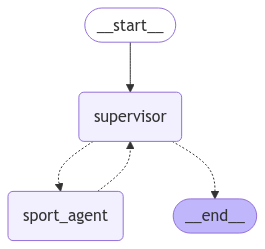

In [84]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Testing Agents

In [118]:
for s in graph.stream(
        {'messages': [
            ('user', "What's the age of Sean Manaea?"),
        ]}, subgraphs=True
):
    print(s)
    print("----")

print('\n==============================\n')

# result =  graph.invoke(
#     {'messages': [
#         ('user', "What's the age of Sean Manaea?"),
#     ]}, subgraphs=True)
#
# print(result)

# for s in graph.stream(
#         {'messages': [
#             ('user', "where I can get fresh apples?")
#         ]}, subgraphs=True
# ):
#     print(s)
#     print("----")

((), {'supervisor': {'next': 'sport_agent'}})
----
(('sport_agent:a67b3215-ff52-8413-5e34-99747d77b4d2',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vUBGnx6GHCfbt0KJ7XizA6pY', 'function': {'arguments': '{}', 'name': 'api_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 81, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-17385113-2f5c-4b27-9b8a-2eb3d3a3a974-0', tool_calls=[{'name': 'api_tool', 'args': {}, 'id': 'call_vUBGnx6GHCfbt0KJ7XizA6pY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 81, 'output_tokens': 11, 'total_tokens': 92, 'input_toke